In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras import optimizers
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import precision_recall_fscore_support as score
# define path to save model
model_path = 'Model/multi_model.h5'

# read training data - It is the aircraft engine run-to-failure data. (failure and testing)
# read test data - It is the aircraft engine operating data without failure events recorded.
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)

# Drop missing data columns(redundant)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# Sorting and indicating columns
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']



Using TensorFlow backend.


In [2]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
# pd.set_option('display.max_rows', 5000)
# print (train_df.head(5000))


## Generate multi classes for softmax multiclass classification
# class0 = 1, if label2 is 0
# class1 = 1, if label2 is 1
# class2 = 1, if label2 is 2

# extract label2 as numpy array
# pd series to numpy array
label2_array = train_df['label2'].to_numpy()
print (type(label2_array))

class0_array = np.zeros(len(label2_array))
class1_array = np.zeros(len(label2_array))
class2_array = np.zeros(len(label2_array))

# assign '1' to generate one hot encoding vector for each class
class0_array[label2_array==0] = 1
class1_array[label2_array==1] = 1
class2_array[label2_array==2] = 1

#check
print (class0_array.shape)
print (class1_array)
print (class2_array)
train_df['class0'] = class0_array
train_df['class1'] = class1_array
train_df['class2'] = class2_array

class_idx = np.stack((class0_array, class1_array, class2_array), axis=-1)
print (class_idx.shape)
print (train_df)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2',
                                              'class0','class1','class2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2


## Ground truth of multi class 
# extract label2 as numpy array
# pd series to numpy array
label2_array_test = test_df['label2'].to_numpy()
print (type(label2_array_test))

class0_array_test = np.zeros(len(label2_array_test))
class1_array_test = np.zeros(len(label2_array_test))
class2_array_test = np.zeros(len(label2_array_test))

# assign '1' to generate one hot encoding vector for each class
class0_array_test[label2_array_test==0] = 1
class1_array_test[label2_array_test==1] = 1
class2_array_test[label2_array_test==2] = 1

#check
print (class0_array_test.shape)
print (class1_array_test)
print (class2_array_test)
test_df['class0'] = class0_array_test
test_df['class1'] = class1_array_test
test_df['class2'] = class2_array_test

class_idx_test = np.stack((class0_array_test, class1_array_test, class2_array_test), axis=-1)
print (class_idx_test.shape)
print (test_df)



<class 'numpy.ndarray'>
(20631,)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 1.]
(20631, 3)
        id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   
...    ...    ...       ...       ...       ...     ...     ...      ...   
20626  100    196   -0.0004   -0.0003     100.0  518.67  643.49  1597.98   
20627  100    197   -0.0016   -0.0005     100.0  518.67  643.54  1604.50   
20628  100    198    0.0004    0.0000     100.0  518.67  643.42  1602.46   
20629  100    199   -0.0011    0.0003     100.0  518.67  643.23  1605.26   
20630  100    200   -0.0032   -0.0005     100.0  518.67  643.85  1600.38

In [3]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen_multi = [gen_labels(train_df[train_df['id']==id], sequence_length, ['class0', 'class1', 'class2']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen_multi).astype(np.float32)




nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

print (label_array)
print (label_array.shape)
print (nb_out)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(15631, 3)
3


In [4]:

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network


model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=200,
         return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(
         units=100,
         return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(
          units=60,
          return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(units=nb_out, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# adm = optimizers.Adam(learning_rate=0.0001)
# keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# model.compile(loss='binary_crossentropy', optimizer=adm, metrics=['accuracy'])

print(model.summary())
print (label_array)
print (label_array.shape)

# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 200)           180800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           120400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

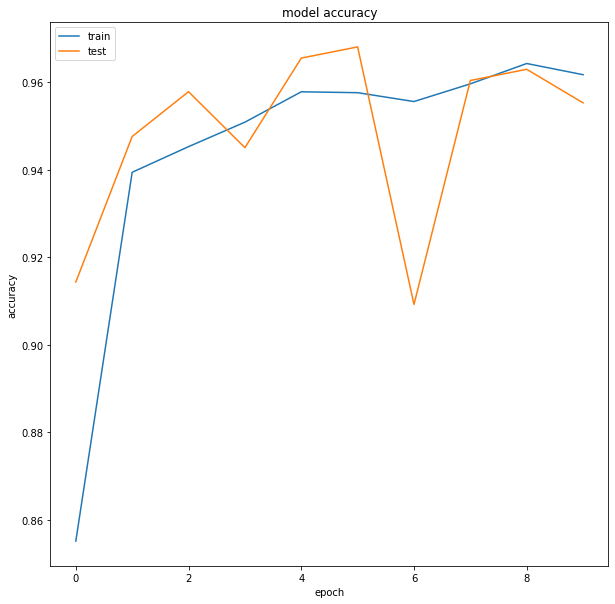

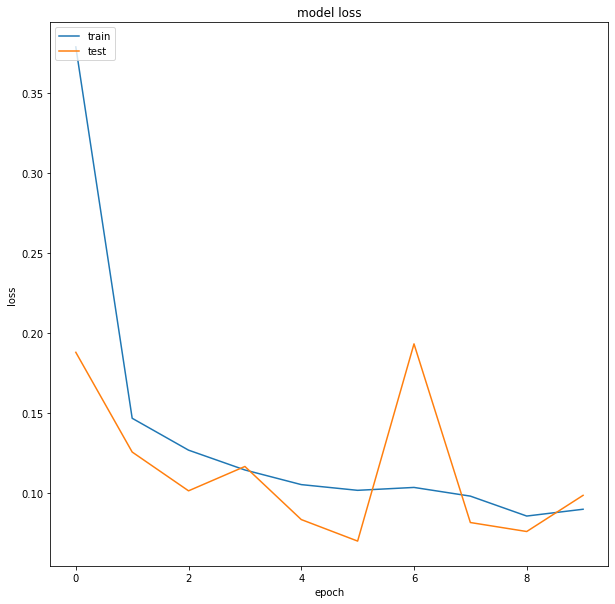

y_true.shape (20631,)
label_array_numeric.shape (15631, 1)
15631/15631 [==============================] - 31s 2ms/step
Accurracy: 0.9660930037498474
15631/15631 [==============================] - 32s 2ms/step


In [35]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Result/multi_model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Result/multi_model_loss.png")


# make predictions and compute confusion matrix
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
label_array_train = train_df['label2'].values.astype(np.float32)

y_true = label_array_train
print ("y_true.shape", y_true.shape)



label_gen_multi_numeric = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label2']) 
             for id in train_df['id'].unique()]

label_array_numeric = np.concatenate(label_gen_multi_numeric).astype(np.float32)
print ("label_array_numeric.shape", label_array_numeric.shape)




# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))



y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)



In [36]:
y_true = label_array_numeric

print ("y_pred", y_pred.shape)
print ("y_true", y_true.shape)



test_set = pd.DataFrame(y_pred)
test_set.to_csv('Result/multi_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# # compute precision and recall
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# print( 'precision = ', precision, '\n', 'recall = ', recall)

y_pred (15631,)
y_true (15631, 1)
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12473    58     0]
 [  290  1164    46]
 [    0   136  1464]]


seq_array_test_last
[[[0.3505747  0.8333333  0.         ... 0.         0.4728682  0.45457056]
  [0.39655173 0.5833333  0.         ... 0.         0.6511628  0.5608948 ]
  [0.5114943  0.25       0.         ... 0.         0.6356589  0.4975145 ]
  ...
  [0.43678162 0.75       0.         ... 0.         0.41860464 0.4710025 ]
  [0.5804598  0.6666667  0.         ... 0.         0.3255814  0.45954156]
  [0.40804598 0.8333333  0.         ... 0.         0.6124031  0.52444077]]

 [[0.55172414 0.25       0.         ... 0.         0.5503876  0.6974593 ]
  [0.39655173 0.5833333  0.         ... 0.         0.37209302 0.59748685]
  [0.5344828  0.16666667 0.         ... 0.         0.51937985 0.602596  ]
  ...
  [0.43103448 0.33333334 0.         ... 0.         0.56589144 0.49461475]
  [0.33908045 0.25       0.         ... 0.         0.4108527  0.5223695 ]
  [0.5689655  0.8333333  0.         ... 0.         0.34108528 0.5024855 ]]

 [[0.7356322  0.25       0.         ... 0.         0.53488374 0.6023198 ]
  

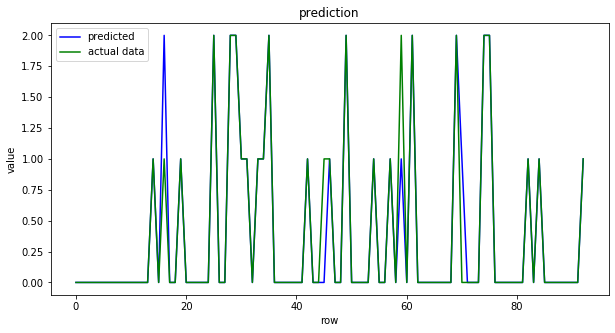

In [28]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label2'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# # test metrics
# scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
# print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
pd.set_option('display.max_rows', 1000)
test_print = pd.DataFrame()
test_print['y_pred']  = y_pred_test.flatten()
test_print['y_truth'] = y_true_test.flatten()
print (test_print)
print ("y_pred_test", y_pred_test)
print ("y_true_test", y_true_test)


test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('Result/multi_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)






precision, recall, fscore, support = score(y_true_test, y_pred_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


# compute precision and recall
# precision_test = precision_score(y_true_test, y_pred_test)
# recall_test = recall_score(y_true_test, y_pred_test)
# f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
# print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("Result/multi_model_verify.png")



